<a href="https://colab.research.google.com/github/khal-drog0/Breast_Cancer_Histopathology_Classification/blob/main/notebook7588f8763a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshvardhanguleria","key":"1fdec53caa8c59a7a088490d95e25316"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json /root/.kaggle

In [5]:
! chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:28<00:00, 97.2MB/s]
100% 3.10G/3.10G [00:28<00:00, 118MB/s] 


In [7]:
! unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import random

In [2]:
images = glob('IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [3]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in images:
    # copying class 0 and class 1 files to class0 and class1 lists,
    # respectively
    if filename.endswith("class0.png"):
        class0.append(filename)
    else:
        class1.append(filename)

In [4]:
print('class0 length:', len(class0))
print('class1 length:', len(class1))

class0 length: 198738
class1 length: 78786


In [5]:
sampled_class0 = random.sample(class0, 20000)
sampled_class1 = random.sample(class1, 20000)
len(sampled_class0)

20000

In [6]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (70, 70), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [7]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [8]:
test = cv2.imread('..//IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
test

In [9]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [11]:
X = np.array(X).reshape(-1, 70, 70, 3)

In [12]:
X.shape

(40000, 70, 70, 3)

In [13]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_predict, y_train, y_true = train_test_split(X, y, test_size = 0.3, random_state = 7)

rate = 0.5
num = int(X.shape[0] * rate)

X_test = X_train[num:]
X_train = X_train[:num]

y_test = y_train[num:]
y_train = y_train[:num]

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_true = to_categorical(y_true, 2)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('X_predict shape : {}' .format(X_predict.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))
print('y_true shape : {}' .format(y_true.shape))

X_train shape : (20000, 70, 70, 3)
X_test shape : (8000, 70, 70, 3)
X_predict shape : (12000, 70, 70, 3)
y_train shape : (20000, 2)
y_test shape : (8000, 2)
y_true shape : (12000, 2)


In [14]:
import matplotlib.pyplot as plt

/home/khal-drog0/.local/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


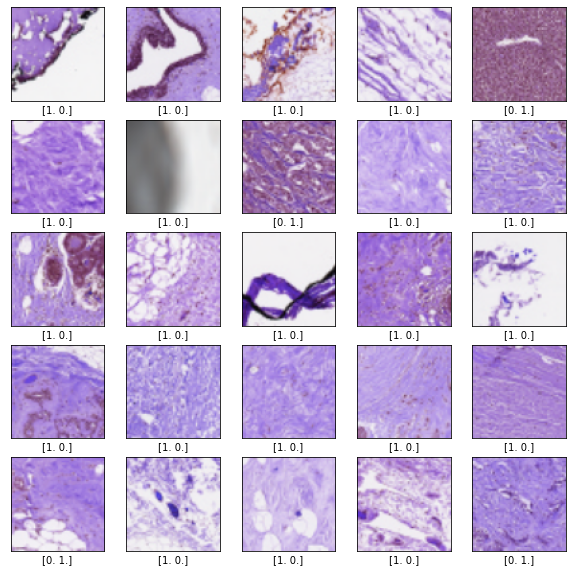

In [15]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [16]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

In [17]:
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K

# Applying Neural Network before applying the Variational Autoencoder

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (70, 70, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (70, 70, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (70, 70, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (70, 70, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(2, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 70, 70, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 35, 35, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 64)        0

In [19]:
import tensorflow as tf

In [20]:
# import tf.keras.optimizers.Adam

Adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = Adam, metrics = ['accuracy'])

In [22]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 100)

Epoch 1/30
200/200 [==============================] - 131s 653ms/step - loss: 0.3077 - accuracy: 0.8712 - val_loss: 0.5844 - val_accuracy: 0.7106
Epoch 2/30
200/200 [==============================] - 130s 651ms/step - loss: 0.3077 - accuracy: 0.8724 - val_loss: 0.5640 - val_accuracy: 0.7484
Epoch 3/30
200/200 [==============================] - 131s 655ms/step - loss: 0.3027 - accuracy: 0.8767 - val_loss: 0.6077 - val_accuracy: 0.6403
Epoch 4/30
200/200 [==============================] - 132s 660ms/step - loss: 0.3028 - accuracy: 0.8767 - val_loss: 0.5988 - val_accuracy: 0.6666
Epoch 5/30
200/200 [==============================] - 123s 616ms/step - loss: 0.2998 - accuracy: 0.8778 - val_loss: 0.5482 - val_accuracy: 0.7750
Epoch 6/30
200/200 [==============================] - 130s 651ms/step - loss: 0.2938 - accuracy: 0.8826 - val_loss: 0.5181 - val_accuracy: 0.7950
Epoch 7/30
200/200 [==============================] - 119s 596ms/step - loss: 0.2940 - accuracy: 0.8836 - val_loss: 0.5528 -

KeyboardInterrupt: 

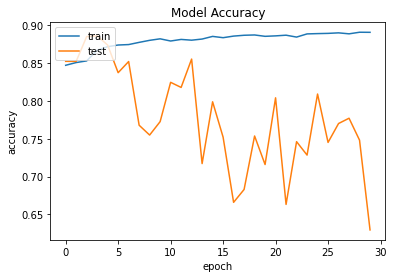

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
result = model.evaluate(X_test, y_test, batch_size = 50)
print('Test Loss, Test Accuracy :', result)

80/80 [==============================] - 7s 93ms/step - loss: 0.6421 - accuracy: 0.6295
Test Loss, Test Accuracy : [0.6420843601226807, 0.6294999718666077]


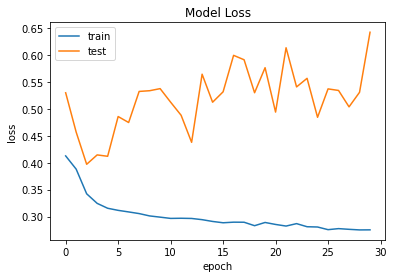

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
P = model.predict(X_predict)

true = 0
for i in range(X_predict.shape[0]):
    if(np.argmax(P[i]) == np.argmax(y_true[i])):
        true = true + 1

pre_accuracy = 100 * float(true/X_predict.shape[0])        
print('Predict Accuracy: {}' .format(pre_accuracy))

Predict Accuracy: 84.66666666666667


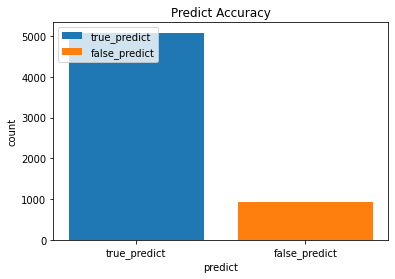

In [ ]:
import seaborn as sns
false = len(X_predict) - true

predict = [true, false]
label = ['true_predict', 'false_predict']

plt.bar(label[0], predict[0])
plt.bar(label[1], predict[1])
plt.title('Predict Accuracy')
plt.xlabel('predict')
plt.ylabel('count')
plt.legend(['true_predict', 'false_predict'], loc='upper left')
plt.show()

# Variational Autoencoder

## Encoder
4 conv2d, 1 flatten and 1 dense layer

In [ ]:
latent_dim = 5 # number of latent dimension parameters

In [ ]:
input_shape = (70, 70, 3)
num_channels = 3
img_width, img_height = (70, 70)

In [ ]:
input_img = Input(shape=input_shape, name='encoder_input')

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

In [ ]:
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder

#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

In [ ]:
# Two outputs, for latent mean and log variance (std. dev.)

z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

In [ ]:
# REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [ ]:
# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
  
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

In [ ]:
#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.

encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 70, 70, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 70, 70, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_13 (Conv2D)             (None, 35, 35, 64)   18496       ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 35, 35, 64)   36928       ['conv2d_13[0][0]']              
                                                                                            

## Decoder
It takes in latent dim as input.

In [ ]:
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

Need to start with a shape that can be remapped to original image shape as we want our final output to be same shape original input.

In [ ]:
# add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)

In [ ]:
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

In [ ]:
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)

In [ ]:
# Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

In [ ]:
# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 5)]               0         
                                                                 
 dense_7 (Dense)             (None, 78400)             470400    
                                                                 
 reshape_1 (Reshape)         (None, 35, 35, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 70, 70, 32)       18464     
 ranspose)                                                       
                                                                 
 decoder_output (Conv2DTrans  (None, 70, 70, 3)        867       
 pose)                                                           
                                                                 
Total params: 489,731
Trainable params: 489,731
Non-trainab

In [ ]:
# apply the decoder to the latent sample 
z_decoded = decoder(z)

VAE is trained using two loss functions reconstruction loss and KL divergence.

In [ ]:
# Custome Loss
# class to define a custom layer with loss
# Loss function = Reconstruction loss + KL divergence loss

class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [ ]:
# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])

y is basically the original image after encoding input img to mu, sigma, z and decoding sampled z values.
This will be used as output for vae

# VAE

In [ ]:
vae = Model(input_img, y, name='vae')

In [ ]:
# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 70, 70, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 70, 70, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_13 (Conv2D)             (None, 35, 35, 64)   18496       ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 35, 35, 64)   36928       ['conv2d_13[0][0]']              
                                                                                                

In [ ]:
# Train autoencoder
vae.fit(X_train, None, epochs = 10, batch_size = 1000, validation_split = 0.2)

Epoch 1/10


TypeError: in user code:

    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/metrics.py", line 178, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/metrics.py", line 471, in update_state  **
        update_total_op = self.total.assign_add(value_sum)
    File "/home/khal-drog0/.local/lib/python3.8/site-packages/keras/engine/keras_tensor.py", line 254, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_sum/Sum:0', description="created by layer 'tf.math.reduce_sum'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


# Visualize Results
Visualize inputs mapped to the Latent space
We have encoded inputs to latent space dimension = 5. 
Extract z_mu --> first parameter in the result of encoder prediction representing mean

In [ ]:
mu, _, _ = encoder.predict(X_test)

#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

Visualize images
Single decoded image with random input latent vector (of size 1x2)
Latent space range is about -5 to 5 so pick random values within this range
Try starting with -1, 1 and slowly go up to -1.5, 1.5 and see how it morphs from one image to the other.

In [ ]:
sample_vector = np.array([[1,-1]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

In [ ]:
n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

Let us automate this process by generating multiple images and plotting

Use decoder to generate images by tweaking latent variables from the latent space

Create a grid of defined size with zeros. 

Take sample from some defined linear space. In this example range [-4, 4]

Feed it to the decoder and update zeros in the figure with output.

In [ ]:
# Create a Grid of latent variables, to be provided as inputs to decoder.predict
# Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

In [ ]:
# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

In [ ]:
plt.figure(figsize=(10, 10))

#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

In [ ]:
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

# Building CNN for classification

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))

model.add(Dropout(0.5))
model.add(Dense(2, activation = 'sigmoid'))

model.summary()

In [ ]:
from keras.optimizers import Adam

Adam = Adam(learning_rate = 0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = Adam, metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 50)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
result = model.evaluate(X_test, y_test, batch_size = 50)
print('Test Loss, Test Accuracy :', result)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
P = model.predict(X_predict)

true = 0
for i in range(X_predict.shape[0]):
    if(np.argmax(P[i]) == np.argmax(y_true[i])):
        true = true + 1

pre_accuracy = 100 * float(true/X_predict.shape[0])        
print('Predict Accuracy: {}' .format(pre_accuracy))

In [ ]:
import seaborn as sns
false = len(X_predict) - true

predict = [true, false]
label = ['true_predict', 'false_predict']

plt.bar(label[0], predict[0])
plt.bar(label[1], predict[1])
plt.title('Predict Accuracy')
plt.xlabel('predict')
plt.ylabel('count')
plt.legend(['true_predict', 'false_predict'], loc='upper left')
plt.show()